In [1]:
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
from glob import glob
from PIL import Image
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
# Load all histories
history1 = pickle.load(open('./files/S1-Big/History1Dict', 'rb'))
history2 = pickle.load(open('./files/S1-Big/History2Dict', 'rb'))
history3 = pickle.load(open('./files/S1-Big/History3Dict', 'rb'))

# Sum all histories into one
total_history = dict()


for some_key in history1.keys():
    current_values = [] # to save values from all three hist dicts
    for hist_dict in [history1, history2, history3]:
        current_values += hist_dict[some_key]
    total_history[some_key] = current_values

# Training Metrics

## Training Loss

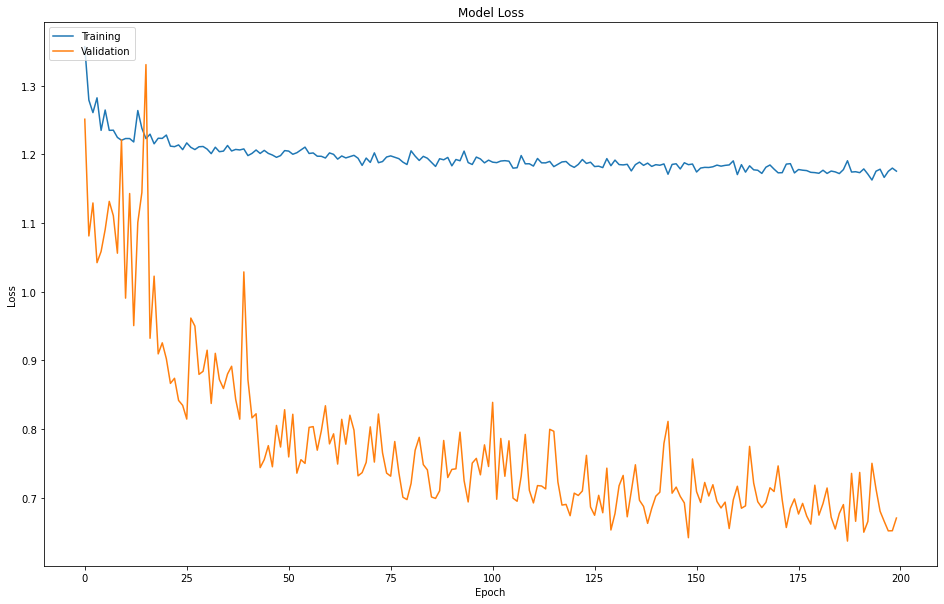

In [3]:
plt.figure(figsize=(16,10))
plt.plot(total_history['loss'])
plt.plot(total_history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Training Accuracy

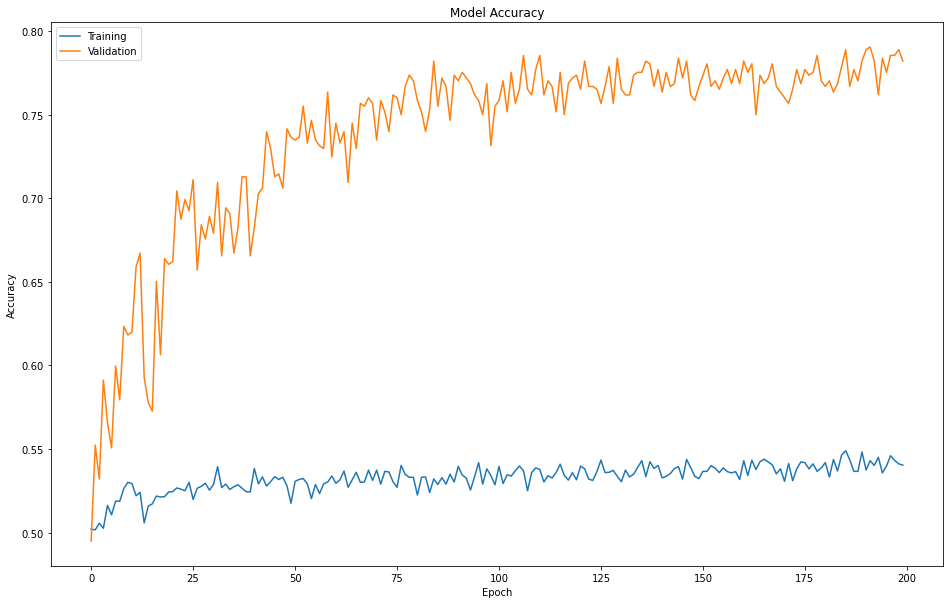

In [4]:
plt.figure(figsize=(16,10))
plt.plot(total_history['accuracy'])
plt.plot(total_history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

# Testing Metrics

## Setup

In [5]:
X_train = np.zeros((5348, 224, 224, 3), dtype=np.uint8)
i = 0

dirs = glob('./datasets/S1-Big/train/*/', recursive=True)
for dir in dirs:
    # Get only one patch from each image to not run out of memory for the .fit
    for infile in glob(dir + '*.png'):
        im = Image.open(infile)         # Loads in PIL format L (grayscale 8 bit)
        im = im.convert('RGB')          # Convert to RGB for fitting
        im = im.resize((224, 224)) 
        X_train[i] = np.array(im)
        i = i+1

## Accuracy and Loss

In [6]:
model = tf.keras.models.load_model('./models/S1-Big_model.h5')

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,                 # Substract mean value of the training dataset
)
# Fit the test_datagen on the training data
test_datagen.fit(X_train)

test_generator = test_datagen.flow_from_directory(
    './datasets/S1-Big/test/',
    target_size=(224,224),
    batch_size=32,
    shuffle=False,
    class_mode='categorical'
)

2022-09-12 18:12:23.371760: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-12 18:12:23.398458: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-12 18:12:23.398752: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-12 18:12:23.399748: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Found 1036 images belonging to 5 classes.


In [7]:
# Returns Test Metrics
model.evaluate(test_generator)

2022-09-12 18:12:50.550345: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


33/33 [==============================] - 35s 295ms/step - loss: 0.5688 - accuracy: 0.7944 - tp: 772.0000 - fp: 142.0000 - tn: 4002.0000 - fn: 264.0000 - precision: 0.8446 - recall: 0.7452 - auc: 0.9593 - prc: 0.8828


[0.5688188672065735,
 0.7944015264511108,
 772.0,
 142.0,
 4002.0,
 264.0,
 0.8446389436721802,
 0.7451737523078918,
 0.9592916369438171,
 0.8828439712524414]

## Confusion Matrix

In [8]:
# Predict on all test images
preds = model.predict(test_generator)

33/33 [==============================] - 5s 147ms/step


{'background': 0, 'calcification_BENIGN': 1, 'calcification_MALIGNANT': 2, 'mass_BENIGN': 3, 'mass_MALIGNANT': 4}


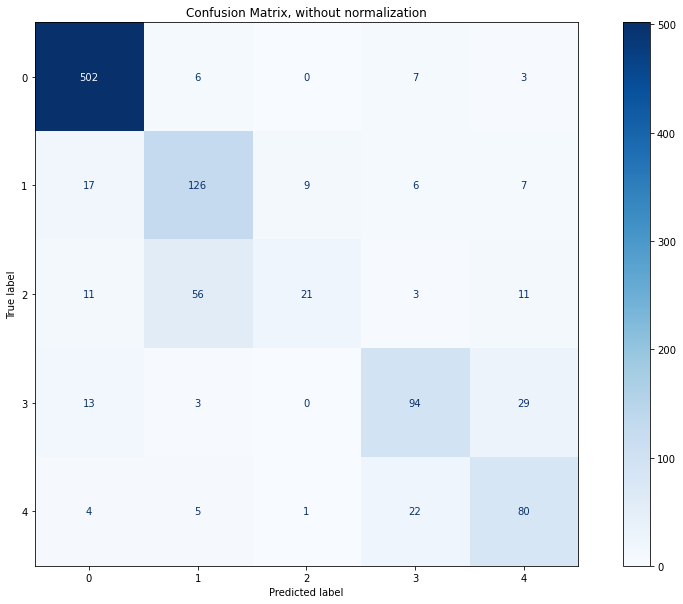

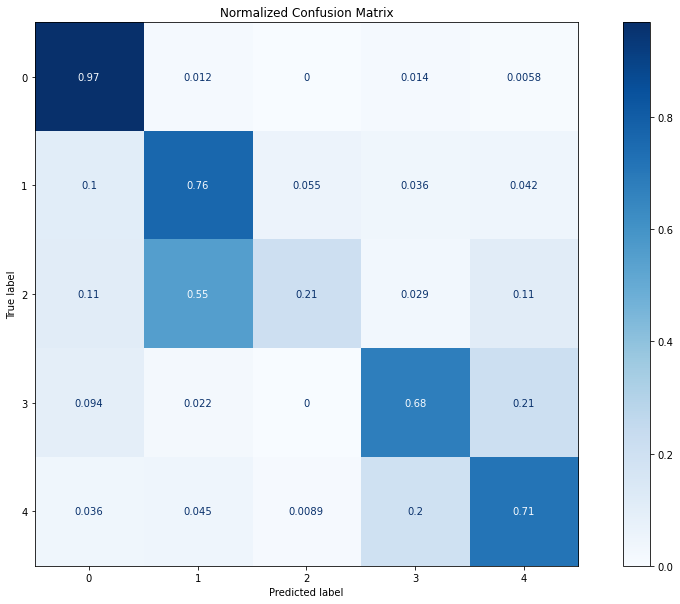

In [9]:
# Get the predict label for each image and give 1d format for confusion matrix
pred_labels = np.argmax(preds, axis=1)

# Get the ground truth labels
true_labels = test_generator.classes

# Plot confusion matrix
titles_options = [
    ('Confusion Matrix, without normalization', None),
    ('Normalized Confusion Matrix', 'true')
]

print(test_generator.class_indices)
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_predictions(
        true_labels,
        pred_labels,
        #display_labels=test_generator.class_indices,
        cmap=plt.cm.Blues,
        normalize=normalize)
    disp.ax_.set_title(title)
    disp.figure_.set(figwidth=16, figheight=10)
    plt.show()

# Images

## Setup

In [10]:
# Print prediction results in a grid
def plot_img_results(array, true, pred, i, n=1):
    # Plot the image and the target for sample i
    ncols = 3
    nrows = n//ncols + 1
    fig = plt.figure(figsize=(ncols*5, nrows*5))
    for j in range(n):
        index = j+i
        plt.subplot(nrows,ncols, j+1)
        plt.imshow(array[index].astype(np.uint8))
        plt.title('True: {}, Pred: {}'.format(true[index], pred[index]))
        plt.axis('off')

In [11]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    #featurewise_center=True,                 # Substract mean value of the training dataset
)
# Fit the test_datagen on the training data
#test_datagen.fit(X_train)

test_generator = test_datagen.flow_from_directory(
    './datasets/S1-Big/test/',
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

Found 1036 images belonging to 5 classes.


## Get Labels

In [12]:
# Predict over the test dataset and see a few samples of correct/incorrect images
X_test, y_test = next(test_generator)
preds = model.predict(X_test)
pred_labels = np.argmax(preds, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Inverse the class mapping for easier understanding
rev_mapping = {v: k for k, v in test_generator.class_indices.items()}

1/1 [==============================] - 1s 750ms/step


## Mispredicted Images

Number of misclassified images: 7

{0: 'background', 1: 'calcification_BENIGN', 2: 'calcification_MALIGNANT', 3: 'mass_BENIGN', 4: 'mass_MALIGNANT'}


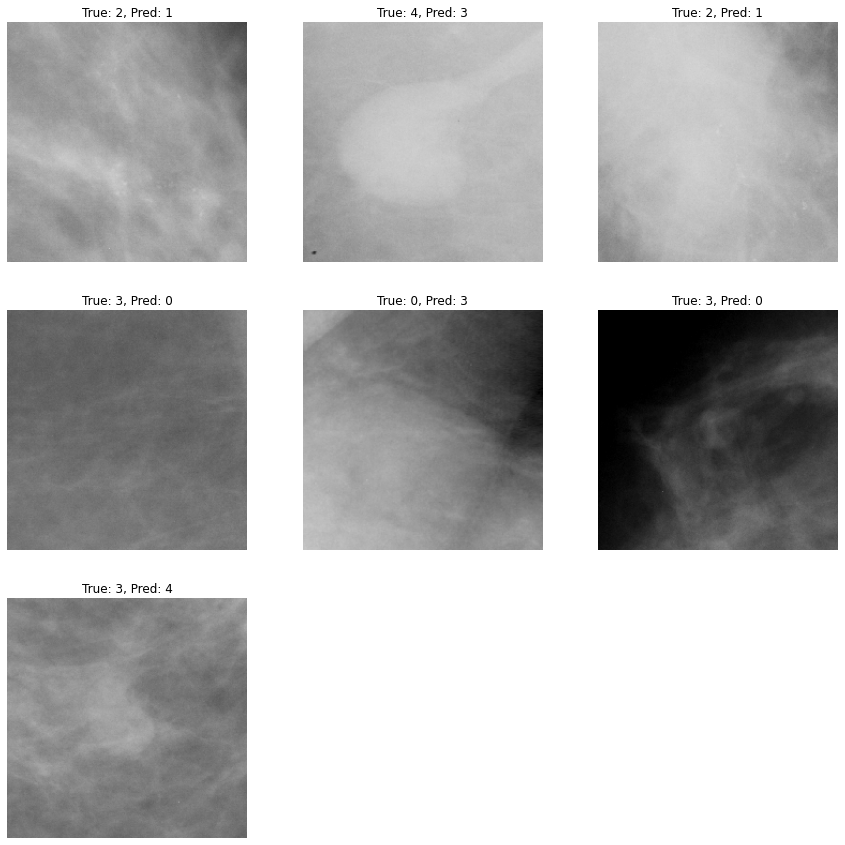

In [13]:
# Find mispredicted labels
mispred_img = X_test[pred_labels!=true_labels]
mispred_true = true_labels[pred_labels!=true_labels]
mispred_pred = pred_labels[pred_labels!=true_labels]
print ('Number of misclassified images:', mispred_img.shape[0])
print()

print(rev_mapping)
plot_img_results(mispred_img, mispred_true, mispred_pred, 0, len(mispred_img))

## Correct Predictions

Number of correctly classified images: 25

{0: 'background', 1: 'calcification_BENIGN', 2: 'calcification_MALIGNANT', 3: 'mass_BENIGN', 4: 'mass_MALIGNANT'}


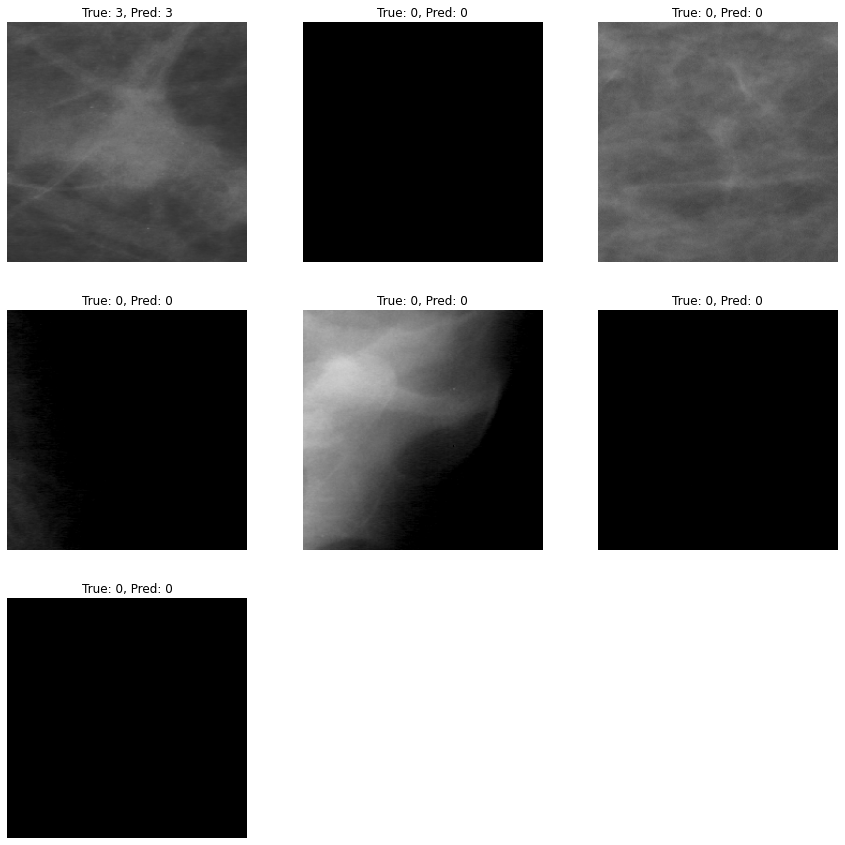

In [14]:
# Find correctly predicted labels
pred_img = X_test[pred_labels==true_labels]
pred_true = true_labels[pred_labels==true_labels]
pred_pred = pred_labels[pred_labels==true_labels]
print ('Number of correctly classified images:', pred_img.shape[0])
print()

print(rev_mapping)
plot_img_results(pred_img, pred_true, pred_pred, 0, len(mispred_img))